<a href="https://colab.research.google.com/github/oimartin/Predicting_House_Prices/blob/main/predicting_home_prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Home Prices EDA

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import cross_val_score, train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_squared_error, make_scorer

from sklearn.linear_model import LinearRegression

# read in training data set for housing prices
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

140000    20
135000    17
145000    14
155000    14
190000    13
          ..
84900      1
424870     1
415298     1
62383      1
34900      1
Name: SalePrice, Length: 663, dtype: int64

163000.0

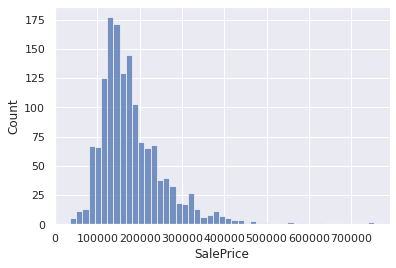

In [2]:
# Observe SalePrice train data
sns.set_theme(color_codes=True)

sns.histplot(train.SalePrice)
display(train.SalePrice.value_counts(dropna=False))
display(train.SalePrice.median())


In [3]:
# Save SalePrice train data and drop from df for independent variable preprocessing
y = train['SalePrice']
train = train.drop(columns=['SalePrice'])
display(y.describe())
display(train.info())

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

None

In [4]:
# Observe info about test data
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

In [5]:
# Concatenate train and test independent variable data so manipulations happend to both data sets
data = pd.concat([train, test])
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2919 non-null   int64  
 1   MSSubClass     2919 non-null   int64  
 2   MSZoning       2915 non-null   object 
 3   LotFrontage    2433 non-null   float64
 4   LotArea        2919 non-null   int64  
 5   Street         2919 non-null   object 
 6   Alley          198 non-null    object 
 7   LotShape       2919 non-null   object 
 8   LandContour    2919 non-null   object 
 9   Utilities      2917 non-null   object 
 10  LotConfig      2919 non-null   object 
 11  LandSlope      2919 non-null   object 
 12  Neighborhood   2919 non-null   object 
 13  Condition1     2919 non-null   object 
 14  Condition2     2919 non-null   object 
 15  BldgType       2919 non-null   object 
 16  HouseStyle     2919 non-null   object 
 17  OverallQual    2919 non-null   int64  
 18  OverallC

In [6]:
# Show columns with the missing values
data_na = pd.DataFrame([data.isna()[column].value_counts() 
                         for column in data.columns]).reset_index()
                         
top_na = data_na.rename(columns={'index':'Column',
                             0:'Present',
                             1:'Missing'}).sort_values(by='Missing',
                                                       ascending=False).head(34)
display(top_na)

,Column,Present,Missing
72,PoolQC,10.0,2909.0
74,MiscFeature,105.0,2814.0
6,Alley,198.0,2721.0
73,Fence,571.0,2348.0
57,FireplaceQu,1499.0,1420.0
3,LotFrontage,2433.0,486.0
60,GarageFinish,2760.0,159.0
63,GarageQual,2760.0,159.0
64,GarageCond,2760.0,159.0
59,GarageYrBlt,2760.0,159.0


34

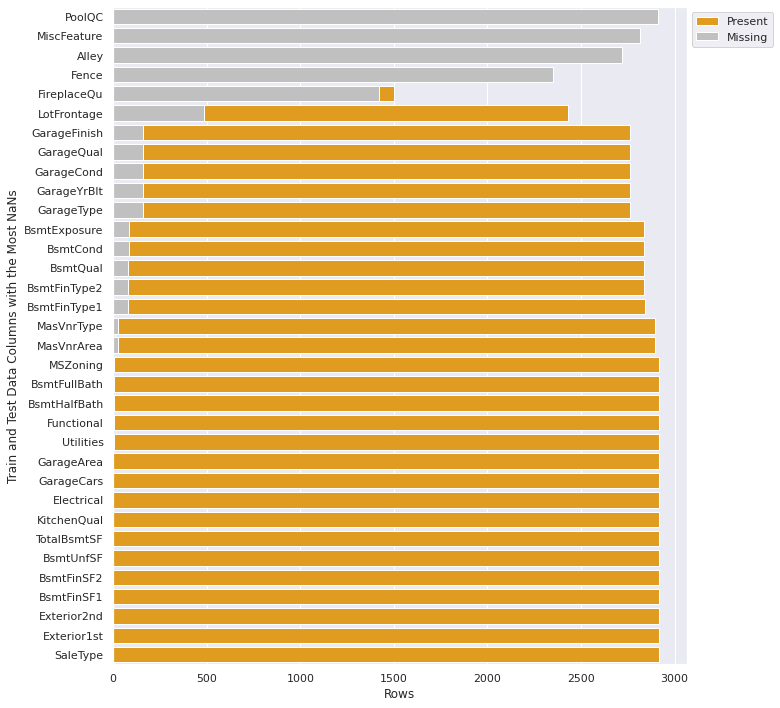

In [7]:
sns.set_theme(color_codes=True)

# Create barplot of the columns with the most missing data
plt.figure(figsize=(11,10), frameon=False)
sns.set_color_codes("pastel")
ax = sns.barplot(x="Present", y="Column", data=top_na,
            label="Present", color="orange")

sns.set_color_codes("muted")
ax = sns.barplot(x="Missing", y="Column", data=top_na,
           label='Missing', color='silver')

ax.legend()
sns.move_legend(ax, "upper left", bbox_to_anchor=(1,1))
plt.xlabel('Rows')
plt.ylabel('Train and Test Data Columns with the Most NaNs')
ax.figure.savefig('figures/missing_data.png')
plt.tight_layout()


In [8]:
# Identify columns with int or float with missing data
numerical_missing = list(train[list(top_na['Column'])].describe().columns)
numerical_missing

['LotFrontage',
 'GarageYrBlt',
 'MasVnrArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'GarageArea',
 'GarageCars',
 'TotalBsmtSF',
 'BsmtUnfSF',
 'BsmtFinSF2',
 'BsmtFinSF1']

In [9]:
# Fill numerical missing data with median of that feature
data_num_fill = pd.DataFrame()
data_num_fill = data[numerical_missing].copy()

for feature in numerical_missing:
  data_num_fill[feature] = data_num_fill[feature].fillna(data_num_fill[feature].median())

data[numerical_missing] = data_num_fill[numerical_missing]


In [10]:
# Identify categorical missing data columns
categorical_missing = []
for element in list(top_na['Column']):
  if element not in numerical_missing:
      categorical_missing.append(element)

data[categorical_missing].head()

,PoolQC,MiscFeature,Alley,Fence,FireplaceQu,GarageFinish,GarageQual,GarageCond,GarageType,BsmtExposure,BsmtCond,BsmtQual,BsmtFinType2,BsmtFinType1,MasVnrType,MSZoning,Functional,Utilities,Electrical,KitchenQual,Exterior2nd,Exterior1st,SaleType
0,NaN,NaN,NaN,NaN,NaN,RFn,TA,TA,Attchd,No,TA,Gd,Unf,GLQ,BrkFace,RL,Typ,AllPub,SBrkr,Gd,VinylSd,VinylSd,WD
1,NaN,NaN,NaN,NaN,TA,RFn,TA,TA,Attchd,Gd,TA,Gd,Unf,ALQ,None,RL,Typ,AllPub,SBrkr,TA,MetalSd,MetalSd,WD
2,NaN,NaN,NaN,NaN,TA,RFn,TA,TA,Attchd,Mn,TA,Gd,Unf,GLQ,BrkFace,RL,Typ,AllPub,SBrkr,Gd,VinylSd,VinylSd,WD
3,NaN,NaN,NaN,NaN,Gd,Unf,TA,TA,Detchd,No,Gd,TA,Unf,ALQ,None,RL,Typ,AllPub,SBrkr,Gd,Wd Shng,Wd Sdng,WD
4,NaN,NaN,NaN,NaN,TA,RFn,TA,TA,Attchd,Av,TA,Gd,Unf,GLQ,BrkFace,RL,Typ,AllPub,SBrkr,Gd,VinylSd,VinylSd,WD


In [11]:
# Observe degree of missing data from categorical columns
data[categorical_missing].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 23 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   PoolQC        10 non-null     object
 1   MiscFeature   105 non-null    object
 2   Alley         198 non-null    object
 3   Fence         571 non-null    object
 4   FireplaceQu   1499 non-null   object
 5   GarageFinish  2760 non-null   object
 6   GarageQual    2760 non-null   object
 7   GarageCond    2760 non-null   object
 8   GarageType    2762 non-null   object
 9   BsmtExposure  2837 non-null   object
 10  BsmtCond      2837 non-null   object
 11  BsmtQual      2838 non-null   object
 12  BsmtFinType2  2839 non-null   object
 13  BsmtFinType1  2840 non-null   object
 14  MasVnrType    2895 non-null   object
 15  MSZoning      2915 non-null   object
 16  Functional    2917 non-null   object
 17  Utilities     2917 non-null   object
 18  Electrical    2918 non-null   object
 19  Kitche

In [12]:
# Modify categorical variables where NA means no feature
# Alley and Fence will be modiefied in next step
remove = ['QC', 'Qu', 'Type', 'Finish', 'Qual', 'Feature',
          'Cond', 'Exposure', 'FinType1', 'FinType2']

data_cat_fill = pd.DataFrame()
data_cat_fill = data[categorical_missing].copy()

for feature in categorical_missing:
  for suffix in remove:
    if feature.endswith(suffix) is True:
      shrt_feat = feature[0:-len(suffix)]
      data_cat_fill[feature] = data_cat_fill[feature].fillna(f"No_{shrt_feat}")

data_cat_fill.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 23 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   PoolQC        2919 non-null   object
 1   MiscFeature   2919 non-null   object
 2   Alley         198 non-null    object
 3   Fence         571 non-null    object
 4   FireplaceQu   2919 non-null   object
 5   GarageFinish  2919 non-null   object
 6   GarageQual    2919 non-null   object
 7   GarageCond    2919 non-null   object
 8   GarageType    2919 non-null   object
 9   BsmtExposure  2919 non-null   object
 10  BsmtCond      2919 non-null   object
 11  BsmtQual      2919 non-null   object
 12  BsmtFinType2  2919 non-null   object
 13  BsmtFinType1  2919 non-null   object
 14  MasVnrType    2919 non-null   object
 15  MSZoning      2915 non-null   object
 16  Functional    2917 non-null   object
 17  Utilities     2917 non-null   object
 18  Electrical    2918 non-null   object
 19  Kitche

In [13]:
# Fill columns with NA means No feature, Alley and Fence
data_cat_fill['Alley'] = data_cat_fill['Alley'].fillna('No_Alley')
data_cat_fill['Fence'] = data_cat_fill['Fence'].fillna('No_Fence')
data_cat_fill.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 23 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   PoolQC        2919 non-null   object
 1   MiscFeature   2919 non-null   object
 2   Alley         2919 non-null   object
 3   Fence         2919 non-null   object
 4   FireplaceQu   2919 non-null   object
 5   GarageFinish  2919 non-null   object
 6   GarageQual    2919 non-null   object
 7   GarageCond    2919 non-null   object
 8   GarageType    2919 non-null   object
 9   BsmtExposure  2919 non-null   object
 10  BsmtCond      2919 non-null   object
 11  BsmtQual      2919 non-null   object
 12  BsmtFinType2  2919 non-null   object
 13  BsmtFinType1  2919 non-null   object
 14  MasVnrType    2919 non-null   object
 15  MSZoning      2915 non-null   object
 16  Functional    2917 non-null   object
 17  Utilities     2917 non-null   object
 18  Electrical    2918 non-null   object
 19  Kitche

In [14]:
# Fill missing data of other categorical features where
# NA means unknown 
data_fill_rest = pd.DataFrame()
data_fill_rest = data_cat_fill.copy()

for feature in categorical_missing:
  data_fill_rest[feature] = data_fill_rest[feature].fillna('Unknown')

data[categorical_missing] = data_fill_rest[categorical_missing]

In [15]:
# All categorical missing data has been prepocessed
data[categorical_missing].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 23 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   PoolQC        2919 non-null   object
 1   MiscFeature   2919 non-null   object
 2   Alley         2919 non-null   object
 3   Fence         2919 non-null   object
 4   FireplaceQu   2919 non-null   object
 5   GarageFinish  2919 non-null   object
 6   GarageQual    2919 non-null   object
 7   GarageCond    2919 non-null   object
 8   GarageType    2919 non-null   object
 9   BsmtExposure  2919 non-null   object
 10  BsmtCond      2919 non-null   object
 11  BsmtQual      2919 non-null   object
 12  BsmtFinType2  2919 non-null   object
 13  BsmtFinType1  2919 non-null   object
 14  MasVnrType    2919 non-null   object
 15  MSZoning      2919 non-null   object
 16  Functional    2919 non-null   object
 17  Utilities     2919 non-null   object
 18  Electrical    2919 non-null   object
 19  Kitche

In [16]:
# Differentiate numerical features (minus the target) and categorical features
# Inspired by JulienCS's script: https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset
categorical_features = data.select_dtypes(include = ["object"]).columns
numerical_features = data.select_dtypes(exclude = ["object"]).columns

In [17]:
# Use label encoder to create encoded categories
cat_encoded = pd.DataFrame()
cat_encoded = data[list(categorical_features)].copy()

le = LabelEncoder()

for feature in categorical_features:
  cat_encoded[f"{feature}_en"] = le.fit_transform(data[feature])

cat_encoded = cat_encoded.iloc[:, 43:].copy()
cat_encoded.head()

,MSZoning_en,Street_en,Alley_en,LotShape_en,LandContour_en,Utilities_en,LotConfig_en,LandSlope_en,Neighborhood_en,Condition1_en,Condition2_en,BldgType_en,HouseStyle_en,RoofStyle_en,RoofMatl_en,Exterior1st_en,Exterior2nd_en,MasVnrType_en,ExterQual_en,ExterCond_en,Foundation_en,BsmtQual_en,BsmtCond_en,BsmtExposure_en,BsmtFinType1_en,BsmtFinType2_en,Heating_en,HeatingQC_en,CentralAir_en,Electrical_en,KitchenQual_en,Functional_en,FireplaceQu_en,GarageType_en,GarageFinish_en,GarageQual_en,GarageCond_en,PavedDrive_en,PoolQC_en,Fence_en,MiscFeature_en,SaleType_en,SaleCondition_en
0,3,1,1,3,3,0,4,0,5,2,2,0,5,1,1,13,14,1,2,4,2,2,4,3,2,6,1,0,1,4,2,6,3,1,2,5,5,2,3,4,1,9,4
1,3,1,1,3,3,0,2,0,24,1,2,0,2,1,1,8,8,3,3,4,1,2,4,1,0,6,1,0,1,4,4,6,5,1,2,5,5,2,3,4,1,9,4
2,3,1,1,0,3,0,4,0,5,2,2,0,5,1,1,13,14,1,2,4,2,2,4,2,2,6,1,0,1,4,2,6,5,1,2,5,5,2,3,4,1,9,4
3,3,1,1,0,3,0,0,0,6,2,2,0,5,1,1,14,16,3,3,4,0,4,1,3,0,6,1,2,1,4,2,6,2,5,3,5,5,2,3,4,1,9,0
4,3,1,1,0,3,0,2,0,15,2,2,0,5,1,1,13,14,1,2,4,2,2,4,0,2,6,1,0,1,4,2,6,5,1,2,5,5,2,3,4,1,9,4


In [18]:
# Observe pre-encoded categorical data
[display(pd.DataFrame(data[feature].value_counts())) for feature in data[categorical_features]]

,MSZoning
RL,2265
RM,460
FV,139
RH,26
C (all),25
Unknown,4


,Street
Pave,2907
Grvl,12


,Alley
No_Alley,2721
Grvl,120
Pave,78


,LotShape
Reg,1859
IR1,968
IR2,76
IR3,16


,LandContour
Lvl,2622
HLS,120
Bnk,117
Low,60


,Utilities
AllPub,2916
Unknown,2
NoSeWa,1


,LotConfig
Inside,2133
Corner,511
CulDSac,176
FR2,85
FR3,14


,LandSlope
Gtl,2778
Mod,125
Sev,16


,Neighborhood
NAmes,443
CollgCr,267
OldTown,239
Edwards,194
Somerst,182
NridgHt,166
Gilbert,165
Sawyer,151
NWAmes,131
SawyerW,125


,Condition1
Norm,2511
Feedr,164
Artery,92
RRAn,50
PosN,39
RRAe,28
PosA,20
RRNn,9
RRNe,6


,Condition2
Norm,2889
Feedr,13
Artery,5
PosN,4
PosA,4
RRNn,2
RRAn,1
RRAe,1


,BldgType
1Fam,2425
TwnhsE,227
Duplex,109
Twnhs,96
2fmCon,62


,HouseStyle
1Story,1471
2Story,872
1.5Fin,314
SLvl,128
SFoyer,83
2.5Unf,24
1.5Unf,19
2.5Fin,8


,RoofStyle
Gable,2310
Hip,551
Gambrel,22
Flat,20
Mansard,11
Shed,5


,RoofMatl
CompShg,2876
Tar&Grv,23
WdShake,9
WdShngl,7
ClyTile,1
Metal,1
Membran,1
Roll,1


,Exterior1st
VinylSd,1025
MetalSd,450
HdBoard,442
Wd Sdng,411
Plywood,221
CemntBd,126
BrkFace,87
WdShing,56
AsbShng,44
Stucco,43


,Exterior2nd
VinylSd,1014
MetalSd,447
HdBoard,406
Wd Sdng,391
Plywood,270
CmentBd,126
Wd Shng,81
Stucco,47
BrkFace,47
AsbShng,38


,MasVnrType
None,1742
BrkFace,879
Stone,249
BrkCmn,25
No_MasVnr,24


,ExterQual
TA,1798
Gd,979
Ex,107
Fa,35


,ExterCond
TA,2538
Gd,299
Fa,67
Ex,12
Po,3


,Foundation
PConc,1308
CBlock,1235
BrkTil,311
Slab,49
Stone,11
Wood,5


,BsmtQual
TA,1283
Gd,1209
Ex,258
Fa,88
No_Bsmt,81


,BsmtCond
TA,2606
Gd,122
Fa,104
No_Bsmt,82
Po,5


,BsmtExposure
No,1904
Av,418
Gd,276
Mn,239
No_Bsmt,82


,BsmtFinType1
Unf,851
GLQ,849
ALQ,429
Rec,288
BLQ,269
LwQ,154
No_Bsmt,79


,BsmtFinType2
Unf,2493
Rec,105
LwQ,87
No_Bsmt,80
BLQ,68
ALQ,52
GLQ,34


,Heating
GasA,2874
GasW,27
Grav,9
Wall,6
OthW,2
Floor,1


,HeatingQC
Ex,1493
TA,857
Gd,474
Fa,92
Po,3


,CentralAir
Y,2723
N,196


,Electrical
SBrkr,2671
FuseA,188
FuseF,50
FuseP,8
Mix,1
Unknown,1


,KitchenQual
TA,1492
Gd,1151
Ex,205
Fa,70
No_Kitchen,1


,Functional
Typ,2717
Min2,70
Min1,65
Mod,35
Maj1,19
Maj2,9
Unknown,2
Sev,2


,FireplaceQu
No_Fireplace,1420
Gd,744
TA,592
Fa,74
Po,46
Ex,43


,GarageType
Attchd,1723
Detchd,779
BuiltIn,186
No_Garage,157
Basment,36
2Types,23
CarPort,15


,GarageFinish
Unf,1230
RFn,811
Fin,719
No_Garage,159


,GarageQual
TA,2604
No_Garage,159
Fa,124
Gd,24
Po,5
Ex,3


,GarageCond
TA,2654
No_Garage,159
Fa,74
Gd,15
Po,14
Ex,3


,PavedDrive
Y,2641
N,216
P,62


,PoolQC
No_Pool,2909
Gd,4
Ex,4
Fa,2


,Fence
No_Fence,2348
MnPrv,329
GdPrv,118
GdWo,112
MnWw,12


,MiscFeature
No_Misc,2814
Shed,95
Gar2,5
Othr,4
TenC,1


,SaleType
WD,2525
New,239
COD,87
ConLD,26
CWD,12
ConLI,9
ConLw,8
Oth,7
Con,5
No_Sale,1


,SaleCondition
Normal,2402
Partial,245
Abnorml,190
Family,46
Alloca,24
AdjLand,12


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [19]:
# observe post-encoded categorical data
[display(pd.DataFrame(cat_encoded[feature].value_counts())) for feature in cat_encoded.columns]

,MSZoning_en
3,2265
4,460
1,139
2,26
0,25
5,4


,Street_en
1,2907
0,12


,Alley_en
1,2721
0,120
2,78


,LotShape_en
3,1859
0,968
1,76
2,16


,LandContour_en
3,2622
1,120
0,117
2,60


,Utilities_en
0,2916
2,2
1,1


,LotConfig_en
4,2133
0,511
1,176
2,85
3,14


,LandSlope_en
0,2778
1,125
2,16


,Neighborhood_en
12,443
5,267
17,239
7,194
21,182
16,166
8,165
19,151
14,131
20,125


,Condition1_en
2,2511
1,164
0,92
6,50
4,39
5,28
3,20
8,9
7,6


,Condition2_en
2,2889
1,13
0,5
3,4
4,4
7,2
5,1
6,1


,BldgType_en
0,2425
4,227
2,109
3,96
1,62


,HouseStyle_en
2,1471
5,872
0,314
7,128
6,83
4,24
1,19
3,8


,RoofStyle_en
1,2310
3,551
2,22
0,20
4,11
5,5


,RoofMatl_en
1,2876
5,23
6,9
7,7
3,1
4,1
2,1
0,1


,Exterior1st_en
13,1025
8,450
6,442
14,411
9,221
5,126
3,87
15,56
0,44
11,43


,Exterior2nd_en
14,1014
8,447
6,406
15,391
10,270
5,126
16,81
3,47
12,47
0,38


,MasVnrType_en
3,1742
1,879
4,249
0,25
2,24


,ExterQual_en
3,1798
2,979
0,107
1,35


,ExterCond_en
4,2538
2,299
1,67
0,12
3,3


,Foundation_en
2,1308
1,1235
0,311
3,49
4,11
5,5


,BsmtQual_en
4,1283
2,1209
0,258
1,88
3,81


,BsmtCond_en
4,2606
1,122
0,104
2,82
3,5


,BsmtExposure_en
3,1904
0,418
1,276
2,239
4,82


,BsmtFinType1_en
6,851
2,849
0,429
5,288
1,269
3,154
4,79


,BsmtFinType2_en
6,2493
5,105
3,87
4,80
1,68
0,52
2,34


,Heating_en
1,2874
2,27
3,9
5,6
4,2
0,1


,HeatingQC_en
0,1493
4,857
2,474
1,92
3,3


,CentralAir_en
1,2723
0,196


,Electrical_en
4,2671
0,188
1,50
2,8
5,1
3,1


,KitchenQual_en
4,1492
2,1151
0,205
1,70
3,1


,Functional_en
6,2717
3,70
2,65
4,35
0,19
1,9
7,2
5,2


,FireplaceQu_en
3,1420
2,744
5,592
1,74
4,46
0,43


,GarageType_en
1,1723
5,779
3,186
6,157
2,36
0,23
4,15


,GarageFinish_en
3,1230
2,811
0,719
1,159


,GarageQual_en
5,2604
3,159
1,124
2,24
4,5
0,3


,GarageCond_en
5,2654
3,159
1,74
2,15
4,14
0,3


,PavedDrive_en
2,2641
0,216
1,62


,PoolQC_en
3,2909
2,4
0,4
1,2


,Fence_en
4,2348
2,329
0,118
1,112
3,12


,MiscFeature_en
1,2814
3,95
0,5
2,4
4,1


,SaleType_en
9,2525
6,239
0,87
3,26
1,12
4,9
5,8
8,7
2,5
7,1


,SaleCondition_en
4,2402
5,245
0,190
3,46
2,24
1,12


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [20]:
# join encoded categorical data with numerical data
data = data[numerical_features]
data = pd.concat([data, cat_encoded], axis=1)
data.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,MSZoning_en,Street_en,Alley_en,LotShape_en,LandContour_en,Utilities_en,LotConfig_en,LandSlope_en,Neighborhood_en,Condition1_en,Condition2_en,BldgType_en,HouseStyle_en,RoofStyle_en,RoofMatl_en,Exterior1st_en,Exterior2nd_en,MasVnrType_en,ExterQual_en,ExterCond_en,Foundation_en,BsmtQual_en,BsmtCond_en,BsmtExposure_en,BsmtFinType1_en,BsmtFinType2_en,Heating_en,HeatingQC_en,CentralAir_en,Electrical_en,KitchenQual_en,Functional_en,FireplaceQu_en,GarageType_en,GarageFinish_en,GarageQual_en,GarageCond_en,PavedDrive_en,PoolQC_en,Fence_en,MiscFeature_en,SaleType_en,SaleCondition_en
0,1,60,65.0,8450,7,5,2003,2003,196.0,706.0,0.0,150.0,856.0,856,854,0,1710,1.0,0.0,2,1,3,1,8,0,2003.0,2.0,548.0,0,61,0,0,0,0,0,2,2008,3,1,1,3,3,0,4,0,5,2,2,0,5,1,1,13,14,1,2,4,2,2,4,3,2,6,1,0,1,4,2,6,3,1,2,5,5,2,3,4,1,9,4
1,2,20,80.0,9600,6,8,1976,1976,0.0,978.0,0.0,284.0,1262.0,1262,0,0,1262,0.0,1.0,2,0,3,1,6,1,1976.0,2.0,460.0,298,0,0,0,0,0,0,5,2007,3,1,1,3,3,0,2,0,24,1,2,0,2,1,1,8,8,3,3,4,1,2,4,1,0,6,1,0,1,4,4,6,5,1,2,5,5,2,3,4,1,9,4
2,3,60,68.0,11250,7,5,2001,2002,162.0,486.0,0.0,434.0,920.0,920,866,0,1786,1.0,0.0,2,1,3,1,6,1,2001.0,2.0,608.0,0,42,0,0,0,0,0,9,2008,3,1,1,0,3,0,4,0,5,2,2,0,5,1,1,13,14,1,2,4,2,2,4,2,2,6,1,0,1,4,2,6,5,1,2,5,5,2,3,4,1,9,4
3,4,70,60.0,9550,7,5,1915,1970,0.0,216.0,0.0,540.0,756.0,961,756,0,1717,1.0,0.0,1,0,3,1,7,1,1998.0,3.0,642.0,0,35,272,0,0,0,0,2,2006,3,1,1,0,3,0,0,0,6,2,2,0,5,1,1,14,16,3,3,4,0,4,1,3,0,6,1,2,1,4,2,6,2,5,3,5,5,2,3,4,1,9,0
4,5,60,84.0,14260,8,5,2000,2000,350.0,655.0,0.0,490.0,1145.0,1145,1053,0,2198,1.0,0.0,2,1,4,1,9,1,2000.0,3.0,836.0,192,84,0,0,0,0,0,12,2008,3,1,1,0,3,0,2,0,15,2,2,0,5,1,1,13,14,1,2,4,2,2,4,0,2,6,1,0,1,4,2,6,5,1,2,5,5,2,3,4,1,9,4


In [21]:
# Create feature combining MoSold values into seasons
# winter: 12, 1, 2 = 1
# Spring: 3, 4, 5 = 2
# Summer: 6, 7, 8 = 3
# Fall: 9, 10, 11 = 4

data['Season'] = data['MoSold'].replace({12: 1, 1: 1, 2: 1, 3: 2,
                                               4: 2, 5: 2, 6: 3, 7: 3,
                                               8: 3, 9: 4, 10: 4, 11: 4})
data.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,MSZoning_en,Street_en,Alley_en,...,LandContour_en,Utilities_en,LotConfig_en,LandSlope_en,Neighborhood_en,Condition1_en,Condition2_en,BldgType_en,HouseStyle_en,RoofStyle_en,RoofMatl_en,Exterior1st_en,Exterior2nd_en,MasVnrType_en,ExterQual_en,ExterCond_en,Foundation_en,BsmtQual_en,BsmtCond_en,BsmtExposure_en,BsmtFinType1_en,BsmtFinType2_en,Heating_en,HeatingQC_en,CentralAir_en,Electrical_en,KitchenQual_en,Functional_en,FireplaceQu_en,GarageType_en,GarageFinish_en,GarageQual_en,GarageCond_en,PavedDrive_en,PoolQC_en,Fence_en,MiscFeature_en,SaleType_en,SaleCondition_en,Season
0,1,60,65.0,8450,7,5,2003,2003,196.0,706.0,0.0,150.0,856.0,856,854,0,1710,1.0,0.0,2,1,3,1,8,0,2003.0,2.0,548.0,0,61,0,0,0,0,0,2,2008,3,1,1,...,3,0,4,0,5,2,2,0,5,1,1,13,14,1,2,4,2,2,4,3,2,6,1,0,1,4,2,6,3,1,2,5,5,2,3,4,1,9,4,1
1,2,20,80.0,9600,6,8,1976,1976,0.0,978.0,0.0,284.0,1262.0,1262,0,0,1262,0.0,1.0,2,0,3,1,6,1,1976.0,2.0,460.0,298,0,0,0,0,0,0,5,2007,3,1,1,...,3,0,2,0,24,1,2,0,2,1,1,8,8,3,3,4,1,2,4,1,0,6,1,0,1,4,4,6,5,1,2,5,5,2,3,4,1,9,4,2
2,3,60,68.0,11250,7,5,2001,2002,162.0,486.0,0.0,434.0,920.0,920,866,0,1786,1.0,0.0,2,1,3,1,6,1,2001.0,2.0,608.0,0,42,0,0,0,0,0,9,2008,3,1,1,...,3,0,4,0,5,2,2,0,5,1,1,13,14,1,2,4,2,2,4,2,2,6,1,0,1,4,2,6,5,1,2,5,5,2,3,4,1,9,4,4
3,4,70,60.0,9550,7,5,1915,1970,0.0,216.0,0.0,540.0,756.0,961,756,0,1717,1.0,0.0,1,0,3,1,7,1,1998.0,3.0,642.0,0,35,272,0,0,0,0,2,2006,3,1,1,...,3,0,0,0,6,2,2,0,5,1,1,14,16,3,3,4,0,4,1,3,0,6,1,2,1,4,2,6,2,5,3,5,5,2,3,4,1,9,0,1
4,5,60,84.0,14260,8,5,2000,2000,350.0,655.0,0.0,490.0,1145.0,1145,1053,0,2198,1.0,0.0,2,1,4,1,9,1,2000.0,3.0,836.0,192,84,0,0,0,0,0,12,2008,3,1,1,...,3,0,2,0,15,2,2,0,5,1,1,13,14,1,2,4,2,2,4,0,2,6,1,0,1,4,2,6,5,1,2,5,5,2,3,4,1,9,4,1


In [22]:
data.YearBuilt.describe()

count    2919.000000
mean     1971.312778
std        30.291442
min      1872.000000
25%      1953.500000
50%      1973.000000
75%      2001.000000
max      2010.000000
Name: YearBuilt, dtype: float64

In [23]:
# Create 30 year time periods feature
bins = [1870, 1900, 1930, 1960, 1990, 2010]
group_names = [0, 1, 2, 3, 4]
data['YearBuilt_bin'] = pd.cut(data['YearBuilt'], bins, labels=group_names).astype('float')
data.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,MSZoning_en,Street_en,Alley_en,...,Utilities_en,LotConfig_en,LandSlope_en,Neighborhood_en,Condition1_en,Condition2_en,BldgType_en,HouseStyle_en,RoofStyle_en,RoofMatl_en,Exterior1st_en,Exterior2nd_en,MasVnrType_en,ExterQual_en,ExterCond_en,Foundation_en,BsmtQual_en,BsmtCond_en,BsmtExposure_en,BsmtFinType1_en,BsmtFinType2_en,Heating_en,HeatingQC_en,CentralAir_en,Electrical_en,KitchenQual_en,Functional_en,FireplaceQu_en,GarageType_en,GarageFinish_en,GarageQual_en,GarageCond_en,PavedDrive_en,PoolQC_en,Fence_en,MiscFeature_en,SaleType_en,SaleCondition_en,Season,YearBuilt_bin
0,1,60,65.0,8450,7,5,2003,2003,196.0,706.0,0.0,150.0,856.0,856,854,0,1710,1.0,0.0,2,1,3,1,8,0,2003.0,2.0,548.0,0,61,0,0,0,0,0,2,2008,3,1,1,...,0,4,0,5,2,2,0,5,1,1,13,14,1,2,4,2,2,4,3,2,6,1,0,1,4,2,6,3,1,2,5,5,2,3,4,1,9,4,1,4.0
1,2,20,80.0,9600,6,8,1976,1976,0.0,978.0,0.0,284.0,1262.0,1262,0,0,1262,0.0,1.0,2,0,3,1,6,1,1976.0,2.0,460.0,298,0,0,0,0,0,0,5,2007,3,1,1,...,0,2,0,24,1,2,0,2,1,1,8,8,3,3,4,1,2,4,1,0,6,1,0,1,4,4,6,5,1,2,5,5,2,3,4,1,9,4,2,3.0
2,3,60,68.0,11250,7,5,2001,2002,162.0,486.0,0.0,434.0,920.0,920,866,0,1786,1.0,0.0,2,1,3,1,6,1,2001.0,2.0,608.0,0,42,0,0,0,0,0,9,2008,3,1,1,...,0,4,0,5,2,2,0,5,1,1,13,14,1,2,4,2,2,4,2,2,6,1,0,1,4,2,6,5,1,2,5,5,2,3,4,1,9,4,4,4.0
3,4,70,60.0,9550,7,5,1915,1970,0.0,216.0,0.0,540.0,756.0,961,756,0,1717,1.0,0.0,1,0,3,1,7,1,1998.0,3.0,642.0,0,35,272,0,0,0,0,2,2006,3,1,1,...,0,0,0,6,2,2,0,5,1,1,14,16,3,3,4,0,4,1,3,0,6,1,2,1,4,2,6,2,5,3,5,5,2,3,4,1,9,0,1,1.0
4,5,60,84.0,14260,8,5,2000,2000,350.0,655.0,0.0,490.0,1145.0,1145,1053,0,2198,1.0,0.0,2,1,4,1,9,1,2000.0,3.0,836.0,192,84,0,0,0,0,0,12,2008,3,1,1,...,0,2,0,15,2,2,0,5,1,1,13,14,1,2,4,2,2,4,0,2,6,1,0,1,4,2,6,5,1,2,5,5,2,3,4,1,9,4,1,4.0


In [24]:
display(data.GrLivArea.describe())
display(data.GarageArea.describe())
display(data.TotalBsmtSF.describe())

count    2919.000000
mean     1500.759849
std       506.051045
min       334.000000
25%      1126.000000
50%      1444.000000
75%      1743.500000
max      5642.000000
Name: GrLivArea, dtype: float64

count    2919.000000
mean      472.877013
std       215.357944
min         0.000000
25%       320.000000
50%       480.000000
75%       576.000000
max      1488.000000
Name: GarageArea, dtype: float64

count    2919.000000
mean     1051.756252
std       440.692234
min         0.000000
25%       793.000000
50%       989.500000
75%      1302.000000
max      6110.000000
Name: TotalBsmtSF, dtype: float64

In [25]:
# Create feature combining structure area of AboveGround Living Area, Garage Area, and Bsmt Area
data['TotalStructureArea'] = data['GrLivArea'] + data['GarageArea'] + data['TotalBsmtSF']
data.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,MSZoning_en,Street_en,Alley_en,...,LotConfig_en,LandSlope_en,Neighborhood_en,Condition1_en,Condition2_en,BldgType_en,HouseStyle_en,RoofStyle_en,RoofMatl_en,Exterior1st_en,Exterior2nd_en,MasVnrType_en,ExterQual_en,ExterCond_en,Foundation_en,BsmtQual_en,BsmtCond_en,BsmtExposure_en,BsmtFinType1_en,BsmtFinType2_en,Heating_en,HeatingQC_en,CentralAir_en,Electrical_en,KitchenQual_en,Functional_en,FireplaceQu_en,GarageType_en,GarageFinish_en,GarageQual_en,GarageCond_en,PavedDrive_en,PoolQC_en,Fence_en,MiscFeature_en,SaleType_en,SaleCondition_en,Season,YearBuilt_bin,TotalStructureArea
0,1,60,65.0,8450,7,5,2003,2003,196.0,706.0,0.0,150.0,856.0,856,854,0,1710,1.0,0.0,2,1,3,1,8,0,2003.0,2.0,548.0,0,61,0,0,0,0,0,2,2008,3,1,1,...,4,0,5,2,2,0,5,1,1,13,14,1,2,4,2,2,4,3,2,6,1,0,1,4,2,6,3,1,2,5,5,2,3,4,1,9,4,1,4.0,3114.0
1,2,20,80.0,9600,6,8,1976,1976,0.0,978.0,0.0,284.0,1262.0,1262,0,0,1262,0.0,1.0,2,0,3,1,6,1,1976.0,2.0,460.0,298,0,0,0,0,0,0,5,2007,3,1,1,...,2,0,24,1,2,0,2,1,1,8,8,3,3,4,1,2,4,1,0,6,1,0,1,4,4,6,5,1,2,5,5,2,3,4,1,9,4,2,3.0,2984.0
2,3,60,68.0,11250,7,5,2001,2002,162.0,486.0,0.0,434.0,920.0,920,866,0,1786,1.0,0.0,2,1,3,1,6,1,2001.0,2.0,608.0,0,42,0,0,0,0,0,9,2008,3,1,1,...,4,0,5,2,2,0,5,1,1,13,14,1,2,4,2,2,4,2,2,6,1,0,1,4,2,6,5,1,2,5,5,2,3,4,1,9,4,4,4.0,3314.0
3,4,70,60.0,9550,7,5,1915,1970,0.0,216.0,0.0,540.0,756.0,961,756,0,1717,1.0,0.0,1,0,3,1,7,1,1998.0,3.0,642.0,0,35,272,0,0,0,0,2,2006,3,1,1,...,0,0,6,2,2,0,5,1,1,14,16,3,3,4,0,4,1,3,0,6,1,2,1,4,2,6,2,5,3,5,5,2,3,4,1,9,0,1,1.0,3115.0
4,5,60,84.0,14260,8,5,2000,2000,350.0,655.0,0.0,490.0,1145.0,1145,1053,0,2198,1.0,0.0,2,1,4,1,9,1,2000.0,3.0,836.0,192,84,0,0,0,0,0,12,2008,3,1,1,...,2,0,15,2,2,0,5,1,1,13,14,1,2,4,2,2,4,0,2,6,1,0,1,4,2,6,5,1,2,5,5,2,3,4,1,9,4,1,4.0,4179.0


In [26]:
# seperate train data from data df and add SalePrice information back in the df
train_en_fill = data.iloc[:1460]
train_en_fill['SalePrice'] = y.copy()

train_en_fill

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,MSZoning_en,Street_en,Alley_en,...,LandSlope_en,Neighborhood_en,Condition1_en,Condition2_en,BldgType_en,HouseStyle_en,RoofStyle_en,RoofMatl_en,Exterior1st_en,Exterior2nd_en,MasVnrType_en,ExterQual_en,ExterCond_en,Foundation_en,BsmtQual_en,BsmtCond_en,BsmtExposure_en,BsmtFinType1_en,BsmtFinType2_en,Heating_en,HeatingQC_en,CentralAir_en,Electrical_en,KitchenQual_en,Functional_en,FireplaceQu_en,GarageType_en,GarageFinish_en,GarageQual_en,GarageCond_en,PavedDrive_en,PoolQC_en,Fence_en,MiscFeature_en,SaleType_en,SaleCondition_en,Season,YearBuilt_bin,TotalStructureArea,SalePrice
0,1,60,65.0,8450,7,5,2003,2003,196.0,706.0,0.0,150.0,856.0,856,854,0,1710,1.0,0.0,2,1,3,1,8,0,2003.0,2.0,548.0,0,61,0,0,0,0,0,2,2008,3,1,1,...,0,5,2,2,0,5,1,1,13,14,1,2,4,2,2,4,3,2,6,1,0,1,4,2,6,3,1,2,5,5,2,3,4,1,9,4,1,4.0,3114.0,208500
1,2,20,80.0,9600,6,8,1976,1976,0.0,978.0,0.0,284.0,1262.0,1262,0,0,1262,0.0,1.0,2,0,3,1,6,1,1976.0,2.0,460.0,298,0,0,0,0,0,0,5,2007,3,1,1,...,0,24,1,2,0,2,1,1,8,8,3,3,4,1,2,4,1,0,6,1,0,1,4,4,6,5,1,2,5,5,2,3,4,1,9,4,2,3.0,2984.0,181500
2,3,60,68.0,11250,7,5,2001,2002,162.0,486.0,0.0,434.0,920.0,920,866,0,1786,1.0,0.0,2,1,3,1,6,1,2001.0,2.0,608.0,0,42,0,0,0,0,0,9,2008,3,1,1,...,0,5,2,2,0,5,1,1,13,14,1,2,4,2,2,4,2,2,6,1,0,1,4,2,6,5,1,2,5,5,2,3,4,1,9,4,4,4.0,3314.0,223500
3,4,70,60.0,9550,7,5,1915,1970,0.0,216.0,0.0,540.0,756.0,961,756,0,1717,1.0,0.0,1,0,3,1,7,1,1998.0,3.0,642.0,0,35,272,0,0,0,0,2,2006,3,1,1,...,0,6,2,2,0,5,1,1,14,16,3,3,4,0,4,1,3,0,6,1,2,1,4,2,6,2,5,3,5,5,2,3,4,1,9,0,1,1.0,3115.0,140000
4,5,60,84.0,14260,8,5,2000,2000,350.0,655.0,0.0,490.0,1145.0,1145,1053,0,2198,1.0,0.0,2,1,4,1,9,1,2000.0,3.0,836.0,192,84,0,0,0,0,0,12,2008,3,1,1,...,0,15,2,2,0,5,1,1,13,14,1,2,4,2,2,4,0,2,6,1,0,1,4,2,6,5,1,2,5,5,2,3,4,1,9,4,1,4.0,4179.0,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,62.0,7917,6,5,1999,2000,0.0,0.0,0.0,953.0,953.0,953,694,0,1647,0.0,0.0,2,1,3,1,7,1,1999.0,2.0,460.0,0,40,0,0,0,0,0,8,2007,3,1,1,...,0,8,2,2,0,5,1,1,13,14,3,3,4,2,2,4,3,6,6,1,0,1,4,4,6,5,1,2,5,5,2,3,4,1,9,4,3,4.0,3060.0,175000
1456,1457,20,85.0,13175,6,6,1978,1988,119.0,790.0,163.0,589.0,1542.0,2073,0,0,2073,1.0,0.0,2,0,3,1,7,2,1978.0,2.0,500.0,349,0,0,0,0,0,0,2,2010,3,1,1,...,0,14,2,2,0,2,1,1,9,10,4,3,4,1,2,4,3,0,5,1,4,1,4,4,2,5,1,3,5,5,2,3,2,1,9,4,1,3.0,4115.0,210000
1457,1458,70,66.0,9042,7,9,1941,2006,0.0,275.0,0.0,877.0,1152.0,1188,1152,0,2340,0.0,0.0,2,0,4,1,9,2,1941.0,1.0,252.0,0,60,0,0,0,0,2500,5,2010,3,1,1,...,0,6,2,2,0,5,1,1,5,5,3,0,2,4,4,1,3,2,6,1,0,1,4,2,6,2,1,2,5,5,2,3,0,3,9,4,2,2.0,3744.0,266500
1458,1459,20,68.0,9717,5,6,1950,1996,0.0,49.0,1029.0,0.0,1078.0,1078,0,0,1078,1.0,0.0,1,0,2,1,5,0,1950.0,1.0,240.0,366,0,112,0,0,0,0,4,2010,3,1,1,...,0,12,2,2,0,2,3,1,8,8,3,3,4,1,4,4,2,2,5,1,2,1,0,2,6,3,1,3,5,5,2,3,4,1,9,4,2,2.0,2396.0,142125


Text(0, 0.5, 'Variable Correlation \nto Sale Price')

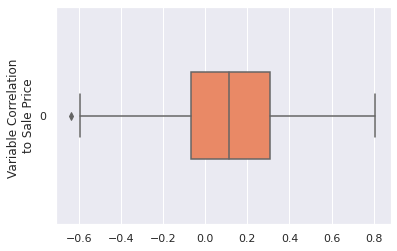

In [27]:
# find correlations between variables and save only 'SalePrice' col
# remove Id and SalePrice columns

SalePrice_corr_train = train_en_fill.corr()['SalePrice'].drop(labels=['Id', 'SalePrice'])

# Create boxplot of all columns with numerical values correlation to saleprice
sns.set_theme(color_codes=True)

# Take out correlation between SalePrice and itself
sns.boxplot(data=SalePrice_corr_train, orient='h', width=0.4,
           color='coral')
plt.ylabel('Variable Correlation \nto Sale Price')

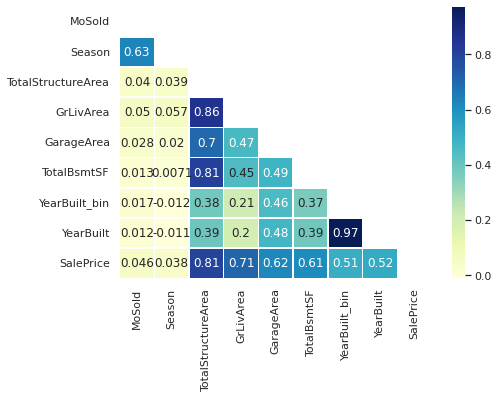

In [52]:
# Create heat map for created features and features used to create them
sns.set_theme(color_codes=True)

features_corr = train_en_fill[['MoSold', 'Season', 'TotalStructureArea', 
                      'GrLivArea', 'GarageArea', 'TotalBsmtSF',
                      'YearBuilt_bin', 'YearBuilt', 'SalePrice']].corr()

mask = np.zeros_like(features_corr)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
  f, ax = plt.subplots(figsize=(7,5))
  ax = sns.heatmap(features_corr, annot=True, linewidths=0.5, cmap="YlGnBu", mask=mask)

ax.figure.savefig(f"figures/created_features_corr.png")

In [53]:
# Observe stats for correlations
display(pd.DataFrame(SalePrice_corr_train.describe()))
corr_stats = SalePrice_corr_train.describe()

,SalePrice
count,82.000000
mean,0.127104
std,0.305754
min,-0.636884
25%,-0.067126
50%,0.112404
75%,0.307919
max,0.807518


In [29]:
# Create list of top 25% and bottom 25% of correlations with Sale Price
SalePrice_corr_train_quarters = SalePrice_corr_train[(SalePrice_corr_train >= corr_stats[6]) 
                     | (SalePrice_corr_train <= corr_stats[4])]

sp_corr = pd.DataFrame(SalePrice_corr_train_quarters.sort_values(ascending=False))

sp_corr

,SalePrice
TotalStructureArea,0.807518
OverallQual,0.790982
GrLivArea,0.708624
GarageCars,0.640409
GarageArea,0.623431
TotalBsmtSF,0.613581
1stFlrSF,0.605852
FullBath,0.560664
TotRmsAbvGrd,0.533723
YearBuilt,0.522897


MSSubClass


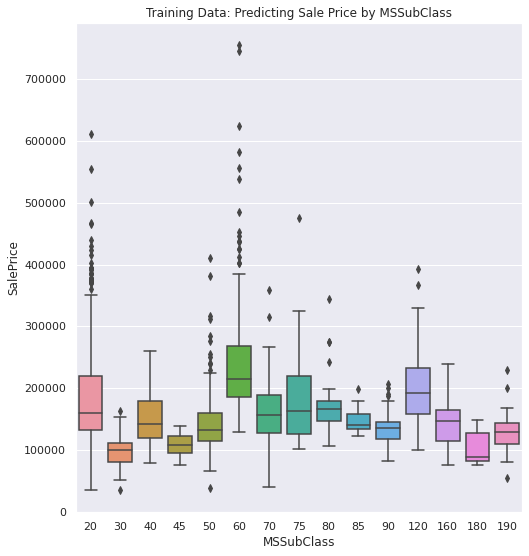

LotFrontage


<Figure size 432x288 with 0 Axes>

<Figure size 576x648 with 0 Axes>

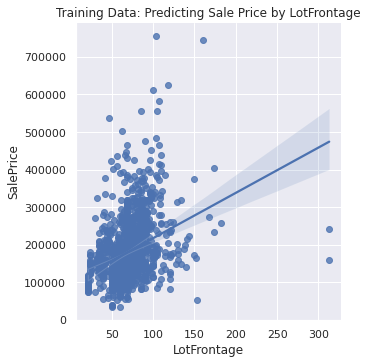

OverallQual


<Figure size 432x288 with 0 Axes>

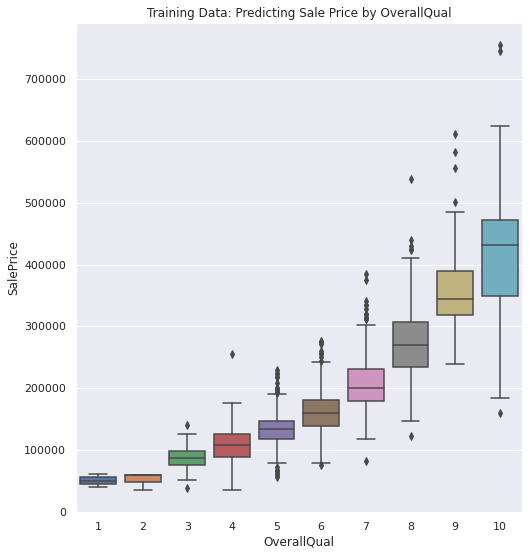

OverallCond


<Figure size 432x288 with 0 Axes>

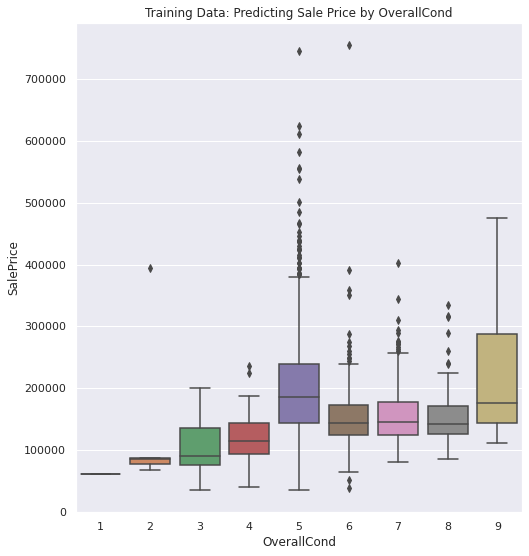

YearBuilt


<Figure size 432x288 with 0 Axes>

<Figure size 576x648 with 0 Axes>

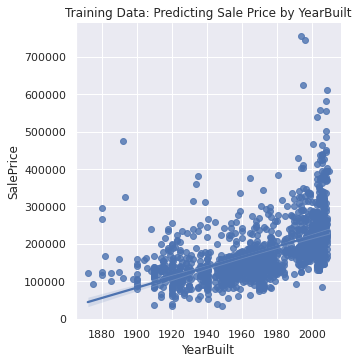

YearRemodAdd


<Figure size 432x288 with 0 Axes>

<Figure size 576x648 with 0 Axes>

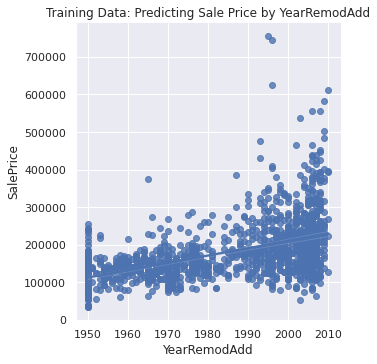

MasVnrArea


<Figure size 432x288 with 0 Axes>

<Figure size 576x648 with 0 Axes>

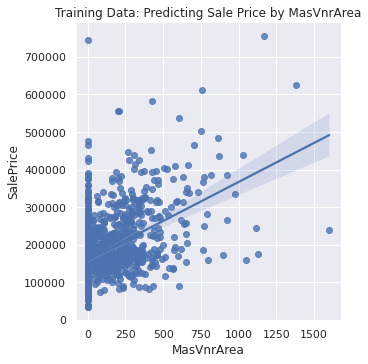

BsmtFinSF1


<Figure size 432x288 with 0 Axes>

<Figure size 576x648 with 0 Axes>

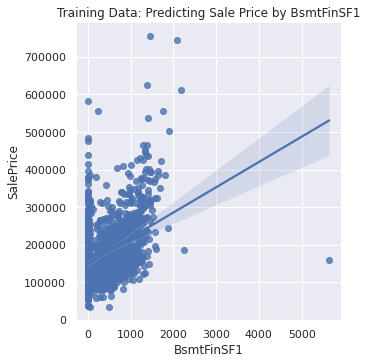

TotalBsmtSF


<Figure size 432x288 with 0 Axes>

<Figure size 576x648 with 0 Axes>

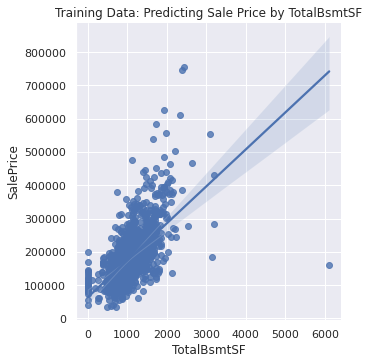

1stFlrSF


<Figure size 432x288 with 0 Axes>

<Figure size 576x648 with 0 Axes>

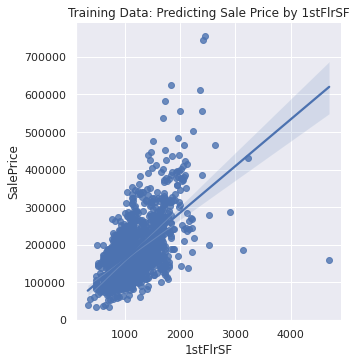

2ndFlrSF


<Figure size 432x288 with 0 Axes>

<Figure size 576x648 with 0 Axes>

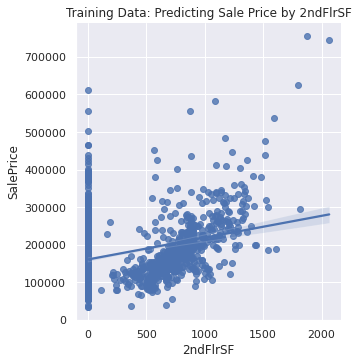

GrLivArea


<Figure size 432x288 with 0 Axes>

<Figure size 576x648 with 0 Axes>

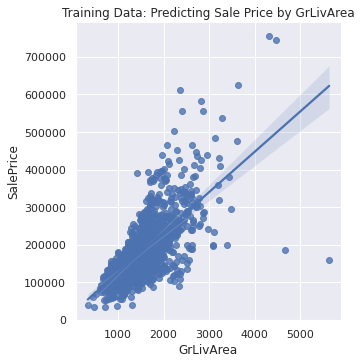

FullBath


<Figure size 432x288 with 0 Axes>

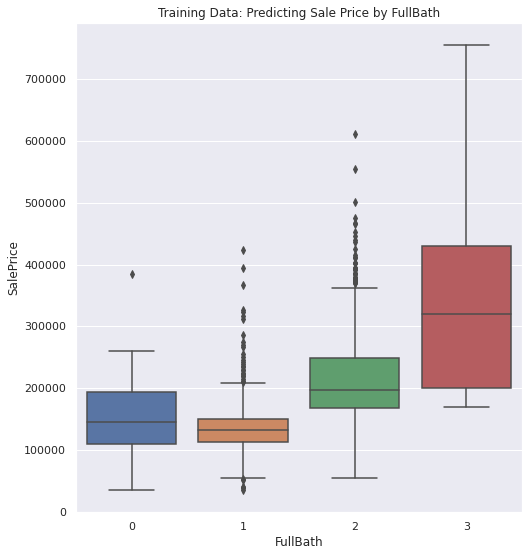

KitchenAbvGr


<Figure size 432x288 with 0 Axes>

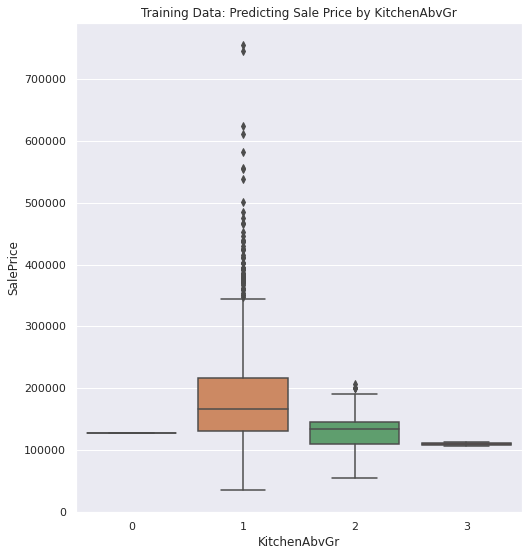

TotRmsAbvGrd


<Figure size 432x288 with 0 Axes>

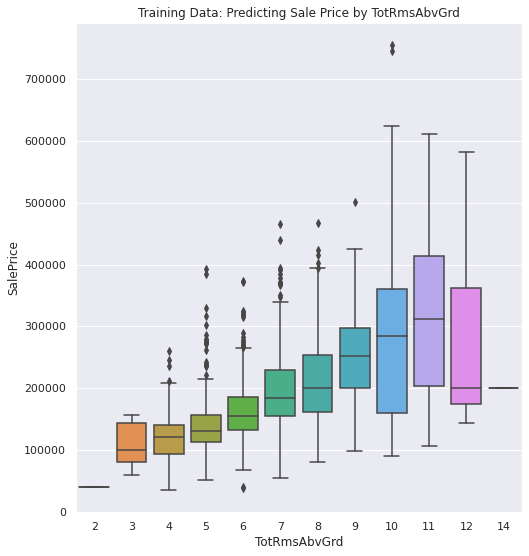

Fireplaces


<Figure size 432x288 with 0 Axes>

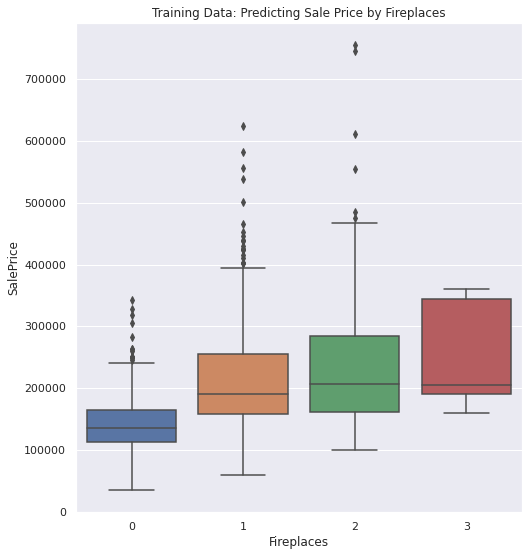

GarageYrBlt


<Figure size 432x288 with 0 Axes>

<Figure size 576x648 with 0 Axes>

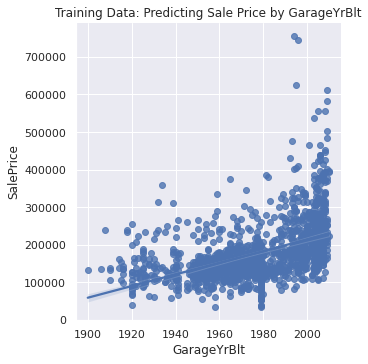

GarageCars


<Figure size 432x288 with 0 Axes>

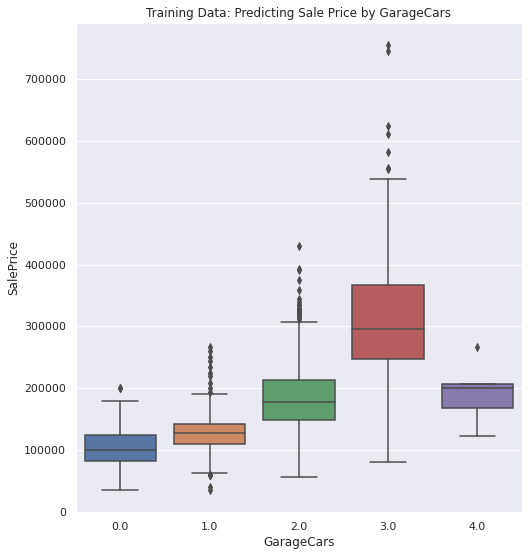

GarageArea


<Figure size 432x288 with 0 Axes>

<Figure size 576x648 with 0 Axes>

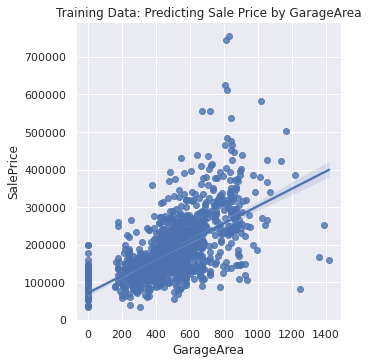

WoodDeckSF


<Figure size 432x288 with 0 Axes>

<Figure size 576x648 with 0 Axes>

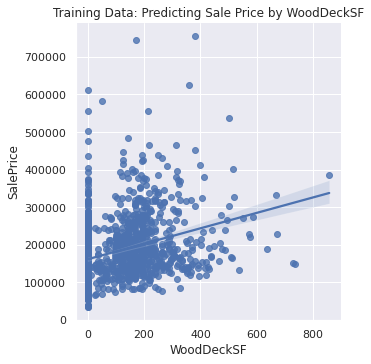

OpenPorchSF


<Figure size 432x288 with 0 Axes>

<Figure size 576x648 with 0 Axes>

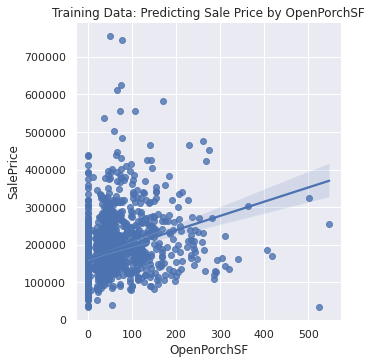

EnclosedPorch


<Figure size 432x288 with 0 Axes>

<Figure size 576x648 with 0 Axes>

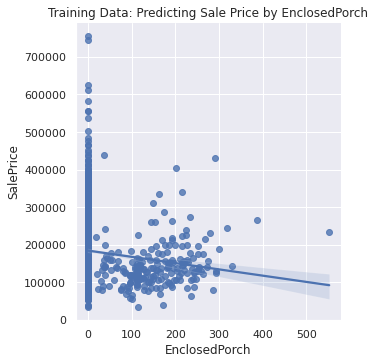

MSZoning_en


<Figure size 432x288 with 0 Axes>

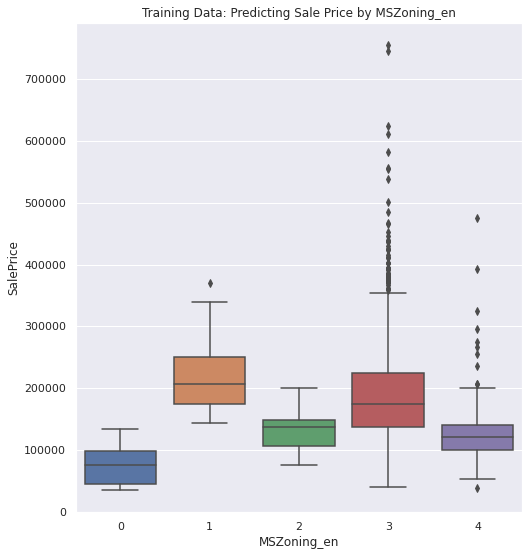

LotShape_en


<Figure size 432x288 with 0 Axes>

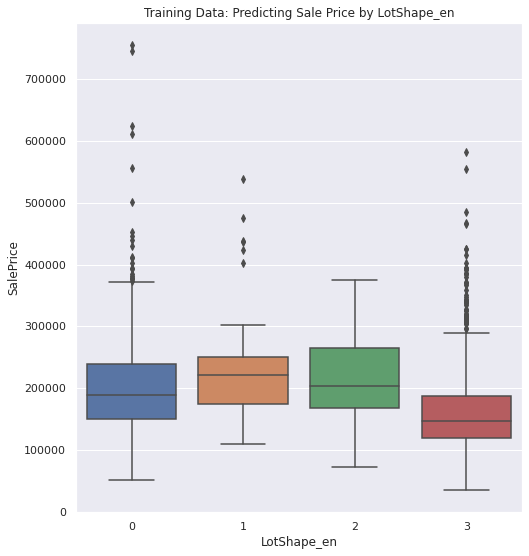

LotConfig_en


<Figure size 432x288 with 0 Axes>

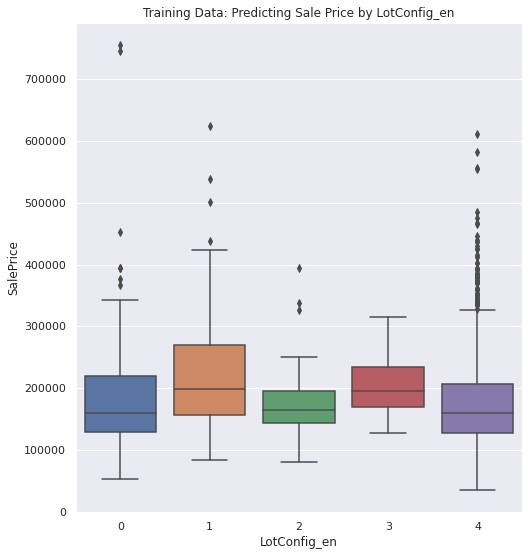

BldgType_en


<Figure size 432x288 with 0 Axes>

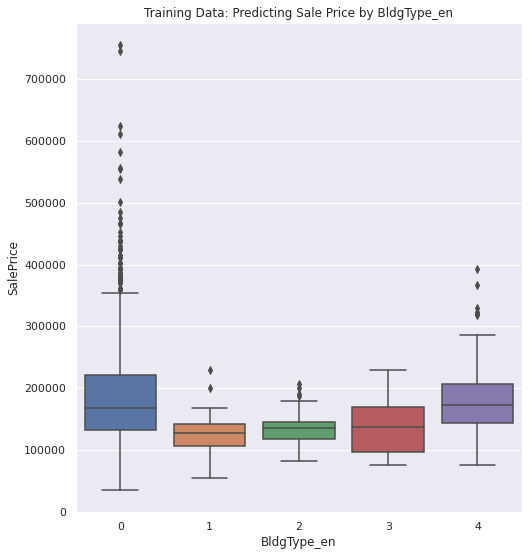

MasVnrType_en


<Figure size 432x288 with 0 Axes>

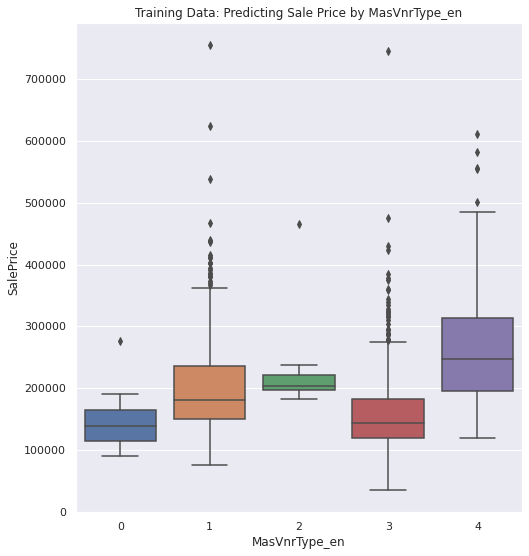

ExterQual_en


<Figure size 432x288 with 0 Axes>

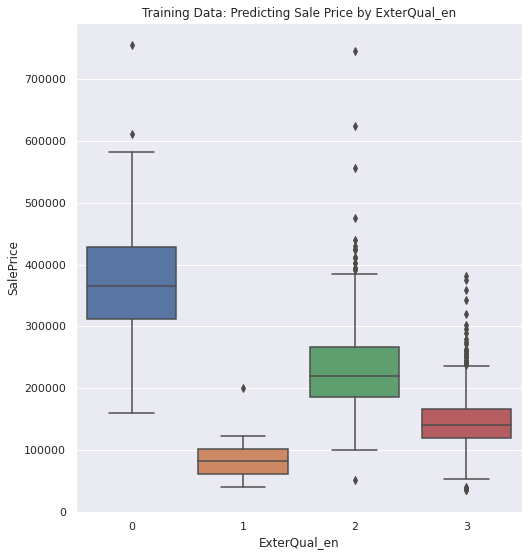

Foundation_en


<Figure size 432x288 with 0 Axes>

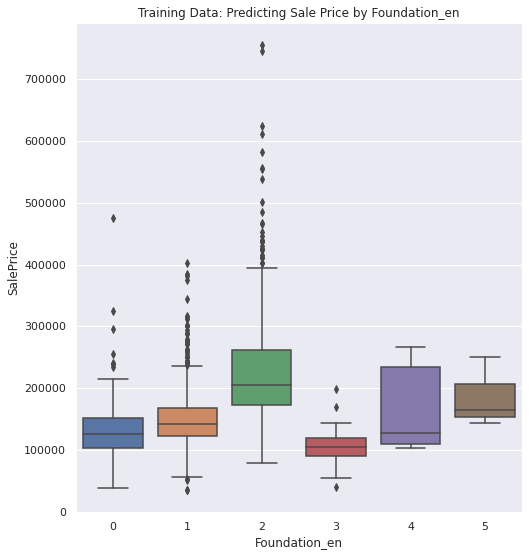

BsmtQual_en


<Figure size 432x288 with 0 Axes>

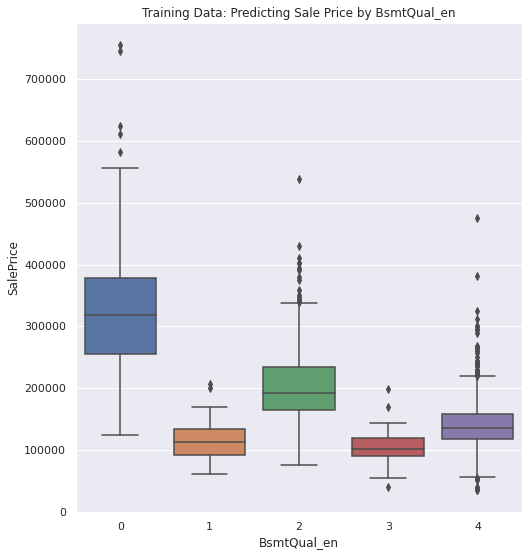

BsmtExposure_en


<Figure size 432x288 with 0 Axes>

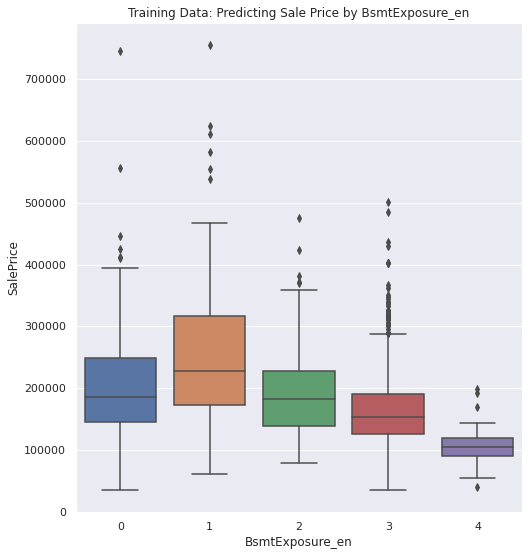

BsmtFinType1_en


<Figure size 432x288 with 0 Axes>

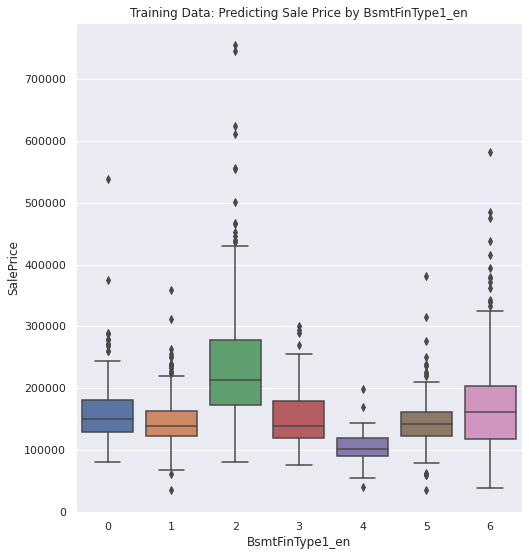

Heating_en


<Figure size 432x288 with 0 Axes>

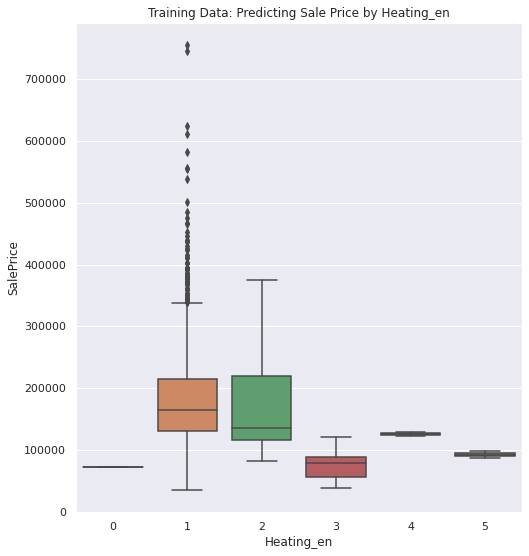

HeatingQC_en


<Figure size 432x288 with 0 Axes>

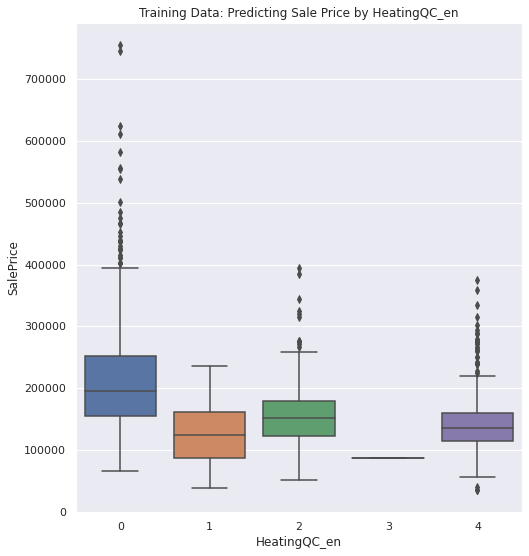

KitchenQual_en


<Figure size 432x288 with 0 Axes>

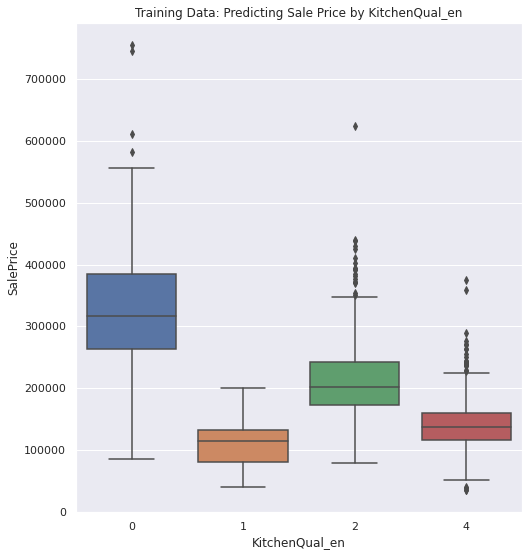

FireplaceQu_en


<Figure size 432x288 with 0 Axes>

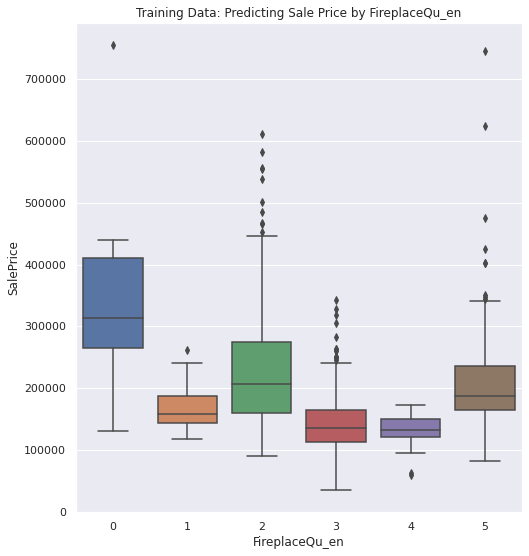

GarageType_en


<Figure size 432x288 with 0 Axes>

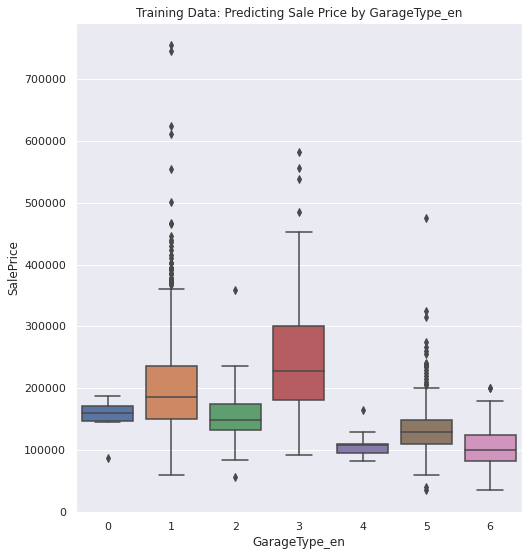

GarageFinish_en


<Figure size 432x288 with 0 Axes>

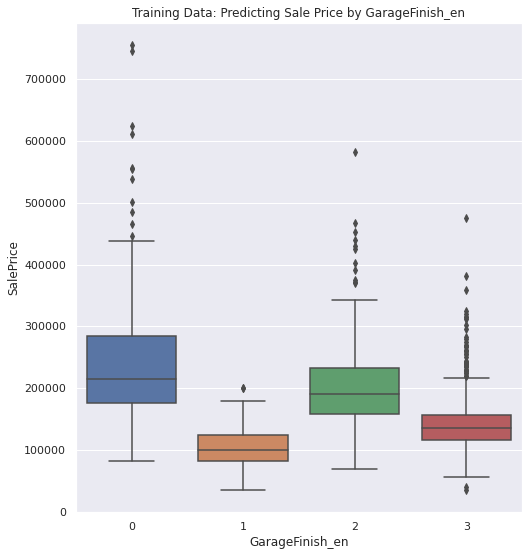

PoolQC_en


<Figure size 432x288 with 0 Axes>

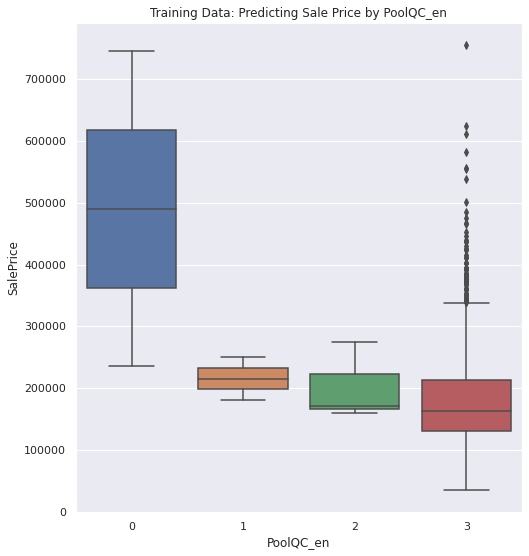

SaleType_en


<Figure size 432x288 with 0 Axes>

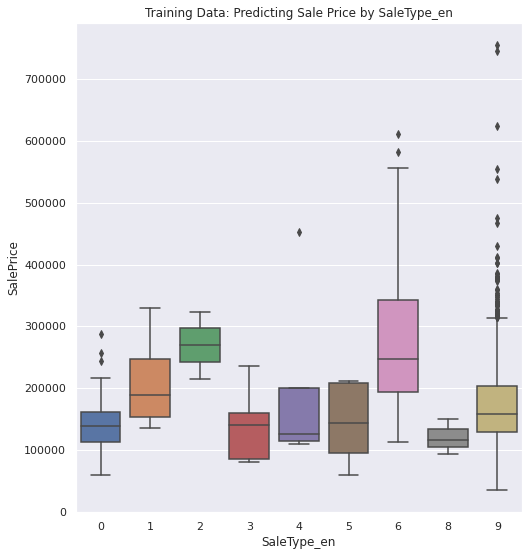

YearBuilt_bin


<Figure size 432x288 with 0 Axes>

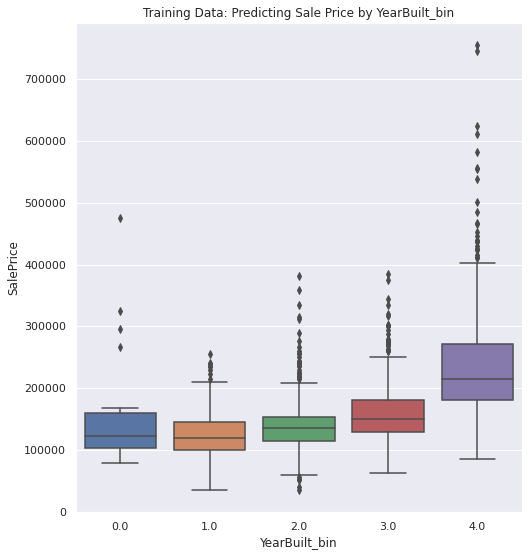

TotalStructureArea


<Figure size 432x288 with 0 Axes>

<Figure size 576x648 with 0 Axes>

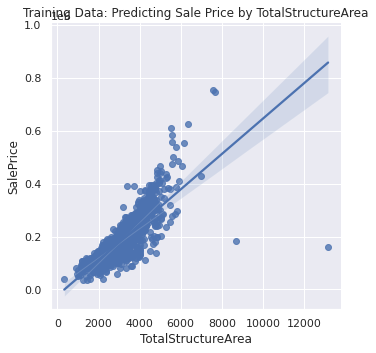

<Figure size 432x288 with 0 Axes>

In [54]:
# Plot independent variables against SalePrice
# Create either a boxplot for variables with less than 50 unique values
# Or scatter plot with regression fit for variables with more than 50 unique values
sns.set_theme(color_codes=True)

for column in list(SalePrice_corr_train_quarters.index):
  if len(train_en_fill[column].value_counts()) <= 50:
      print(f"{column}")
      plt.figure(figsize=(8,9), frameon=False)
      box = sns.boxplot(data=train_en_fill, x=column, y='SalePrice')
      plt.title(f"Training Data: Predicting Sale Price by {column}")
      plt.show()
      box.figure.savefig(f"figures/boxplot_{column}.png")
      plt.tight_layout()
  else:
      print(f"{column}")
      plt.figure(figsize=(8,9), frameon=False)
      lmplot = sns.lmplot(data=train_en_fill, x=column, y='SalePrice')
      plt.title(f"Training Data: Predicting Sale Price by {column}")
      plt.show()
      lmplot.figure.savefig(f"figures/lmplot_{column}.png")
      plt.tight_layout()


In [66]:
# Select independent variables with strong correlations with SalePrice
trained = train_en_fill.drop(columns='SalePrice')
id = trained[['Id']]

trained = trained[['TotalStructureArea', 'OverallQual', 'GarageCars', 'GarageArea',
         'ExterQual_en', 'BsmtQual_en', 'KitchenQual_en', 'GarageFinish_en', 'YearBuilt_bin', 'YearBuilt']]
trained.head()

,TotalStructureArea,OverallQual,GarageCars,GarageArea,ExterQual_en,BsmtQual_en,KitchenQual_en,GarageFinish_en,YearBuilt_bin,YearBuilt
0,3114.0,7,2.0,548.0,2,2,2,2,4.0,2003
1,2984.0,6,2.0,460.0,3,2,4,2,3.0,1976
2,3314.0,7,2.0,608.0,2,2,2,2,4.0,2001
3,3115.0,7,3.0,642.0,3,4,2,3,1.0,1915
4,4179.0,8,3.0,836.0,2,2,2,2,4.0,2000


In [67]:
# Create training and test sets of preprocessed train data
X_train, X_test, y_train, y_test = train_test_split(trained, y, test_size=0.3, random_state=10)
print("X_train : " + str(X_train.shape))
print("X_test : " + str(X_test.shape))
print("y_train : " + str(y_train.shape))
print("y_test : " + str(y_test.shape))

X_train : (1022, 10)
X_test : (438, 10)
y_train : (1022,)
y_test : (438,)


In [68]:
# Differentiate numerical features (minus the target) and categorical features
# Inspired by JulienCS's script: https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset
# Define error measure for official scoring : RMSE
scorer = make_scorer(mean_squared_error, greater_is_better = False)

def rmse_cv_train(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring = scorer, cv = 10))
    return(rmse)

def rmse_cv_test(model):
    rmse= np.sqrt(-cross_val_score(model, X_test, y_test, scoring = scorer, cv = 10))
    return(rmse)

In [69]:
# Use standard scaler with linear regression to observe how train data predictions work
scaler = StandardScaler()

X_train_std  = scaler.fit_transform(X_train.values)
X_test_std = scaler.fit_transform(X_test.values)


lr = LinearRegression()
lr.fit(X_train_std, y_train.values)

print("RMSE on Training set :", rmse_cv_train(lr).mean())
print("RMSE on Test set :", rmse_cv_test(lr).mean())

y_train_pred_std = lr.predict(X_train_std)
y_test_pred_std = lr.predict(X_test_std)

RMSE on Training set : 39115.049032319155
RMSE on Test set : 31232.59257935775


In [70]:
# Use minmax scaler with linear regression to observe  how train data predictions work
mm_scaler = MinMaxScaler()

X_train_mm = mm_scaler.fit_transform(X_train.values)
X_test_mm = mm_scaler.fit_transform(X_test.values)

lr.fit(X_train_mm, y_train.values)

print("RMSE on Training set :", rmse_cv_train(lr).mean())
print("RMSE on Test set :", rmse_cv_test(lr).mean())

y_train_pred_mm = lr.predict(X_train_mm)
y_test_pred_mm = lr.predict(X_test_mm)

RMSE on Training set : 39115.049032319155
RMSE on Test set : 31232.59257935775


In [72]:
# Seperate out testing data from data df
testing = data.iloc[1460:]
id_test = testing['Id']

testing = testing[['TotalStructureArea', 'OverallQual', 'GarageCars', 'GarageArea',
         'ExterQual_en', 'BsmtQual_en', 'KitchenQual_en', 'GarageFinish_en','YearBuilt_bin', 'YearBuilt']]

testing

,TotalStructureArea,OverallQual,GarageCars,GarageArea,ExterQual_en,BsmtQual_en,KitchenQual_en,GarageFinish_en,YearBuilt_bin,YearBuilt
0,2508.0,5,1.0,730.0,3,4,4,3,3.0,1961
1,2970.0,6,1.0,312.0,3,4,2,3,2.0,1958
2,3039.0,5,2.0,482.0,3,2,4,0,4.0,1997
3,3000.0,6,2.0,470.0,3,4,2,0,4.0,1998
4,3066.0,8,2.0,506.0,2,2,2,2,4.0,1992
...,...,...,...,...,...,...,...,...,...,...
1454,1638.0,4,0.0,0.0,3,4,4,1,3.0,1970
1455,1924.0,4,1.0,286.0,3,4,4,3,3.0,1970
1456,3024.0,5,2.0,576.0,3,4,4,3,2.0,1960
1457,1882.0,5,0.0,0.0,3,2,4,1,4.0,1992


In [75]:
# Use standard scaler and linear regression to predict test sale price data
scaler = StandardScaler()

testing_std  = scaler.fit_transform(testing.values)

lr = LinearRegression()
lr.fit(X_train_std, y_train.values)

y_test_pred = lr.predict(testing_std)

pred_test_std_lr = pd.DataFrame()

pred_test_std_lr['Id'] = id_test
pred_test_std_lr['SalePrice'] = y_test_pred
pred_test_std_lr.to_csv('std_lg_houseprice_10.csv', index=False)

In [76]:
# Use minmax scaler and linear regression to predict test sale price data
scaler = MinMaxScaler()

testing_mm  = scaler.fit_transform(testing.values)

lr = LinearRegression()
lr.fit(X_train_mm, y_train.values)

y_test_pred = lr.predict(testing_mm)

pred_test_mm_lr = pd.DataFrame()

pred_test_mm_lr['Id'] = id_test
pred_test_mm_lr['SalePrice'] = y_test_pred
pred_test_mm_lr.to_csv('mm_lg_houseprice_10.csv', index=False)